# Clean and combine COCO datasets

In [1]:
import os
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(10)

### Functions

In [2]:
def get_category_counts(cct):
    '''
    Args:
        cct (dict): A COCO for Cameratraps JSON file parsed into dict

    Returns:
        Returns a dataframe in which each row includes a category and its respective
        number of annotations
    '''
    category_map = {cct['categories'][i]['id']:cct['categories'][i]['name'] for i in range(len(cct['categories']))}
    anns_df = pd.DataFrame(cct['annotations'])
    counts = anns_df.groupby(['category_id']).size().reset_index(name='counts')
    counts['category_name'] = counts['category_id'].map(category_map)
    counts_sorted = counts.sort_values(by=['counts'], ascending=False)

    # Add any categories that had a count of 0
    for orig_cat in cct['categories']:
        if orig_cat['id'] not in counts_sorted.category_id.values:
            cat_to_add = pd.DataFrame([{ 
                'category_id': orig_cat['id'],
                'counts': 0,
                'category_name': orig_cat['name']
            }])
            counts_sorted = pd.concat([counts_sorted, cat_to_add], ignore_index=True)
    
    return counts_sorted

In [3]:
def clean_cct(cct):
    '''
    Clean camera trap annotations in COCO for Cameratraps format
    Filters out annotations (and corresponding images) that:
      - don't have width or height data
      - don't have bounding boxes
      - the bbox is too large (>95% of width OR >95% height of image)

    Args:
        cct (dict): A COCO for Cameratraps JSON file parsed into dict

    Returns:
        A tuple composed of a cleaned, filtered cct dict
        and a dict of rejects (key is reason, values are arrays of file names)
    '''
    print(f'No. annotations BEFORE cleaning: {len(cct["annotations"])}')

    image_lookup = {img['id']: img for img in cct['images']}

    anns_to_keep = []
    images_to_keep = []
    rejects = {
        'bad_locations': [],
        'no_bbox': [],
        'no_dimensions': [],
        'bbox_too_big': [],
    }

    for annotation in cct['annotations']:
        image_id = annotation['image_id']
        image = image_lookup.get(image_id)
        if image is not None:
            bbox = annotation.get('bbox')
            width, height = image.get('width'), image.get('height')
            if bbox is None or None in bbox:
                rejects['no_bbox'].append(image['file_name'])
                continue
            if width is None or height is None:
                rejects['no_dimensions'].append(image['file_name'])
                continue
            if bbox[2] >= 0.95 * width and bbox[3] >= 0.95 * height:
                rejects['bbox_too_big'].append(image['file_name'])
                continue
            anns_to_keep.append(annotation)
            images_to_keep.append(image)

    # de-dupe images (b/c images to annotations is a one-to-many relationship)
    images_df = pd.DataFrame(images_to_keep).drop_duplicates()
    images_to_keep = images_df.to_dict('records')

    print(f'No. annotations AFTER cleaning: {len(anns_to_keep)}')
    print(f'No. images AFTER cleaning: {len(images_to_keep)}')
    for reason, anns in rejects.items():
        print(f'  - {len(anns)} annotations had {reason}')

    return {
      'info': cct['info'],
      'images': images_to_keep,
      'annotations': anns_to_keep,
      'categories': cct['categories']
    }, rejects

In [4]:
def update_categories(cct, category_map):
    '''
    Update and filter camera trap annotations in COCO for Cameratraps format
    based on category_map input

    Args:
        cct (dict): A COCO for Cameratraps JSON file parsed into dict
        category_map (list): A list of dicts that contain category info. E.g.:
            [{'id': 1, 'name': 'occidentalis', 'keep': True, 'convert_to': 'bird'}, ...]

    Returns:
        A tuple composed of an updated, filtered cct dict
        and a dict of rejects (key is reason, values are arrays of file names)
    '''
    print(f'No. annotations BEFORE cleaning: {len(cct["annotations"])}')

    # Add new categories to category_map if necessary
    enriched_category_map = list(category_map)
    for cat in category_map:
        if cat['convert_to'] == None:
            continue
        if cat['convert_to'] not in [cat['name'] for cat in enriched_category_map]:
            enriched_category_map.append({
                'id': len(enriched_category_map),
                'name': cat['convert_to'],
                'keep': True,
                'convert_to': None})

    image_lookup = {img['id']: img for img in cct['images']}
    category_lookup_by_id = {cat['id']: cat for cat in enriched_category_map}
    category_lookup_by_name = {cat['name']: cat for cat in enriched_category_map}

    # update and filter annotations and images
    anns_to_keep = []
    images_to_keep = []
    rejects = { 'dont_keep': [] }
    for annotation in cct['annotations']:
        category_id = annotation['category_id']
        orig_category = category_lookup_by_id.get(category_id)
        image_id = annotation['image_id']
        image = image_lookup.get(image_id)
        if image is not None:
            if orig_category.get('keep') != True:
                # filter non-keepers
                rejects['dont_keep'].append(image['file_name'])
                continue
            if orig_category.get('convert_to') is not None:
                # convert category
                annotation['category_id'] = category_lookup_by_name.get(orig_category.get('convert_to')).get('id')
            anns_to_keep.append(annotation)
            images_to_keep.append(image)

    # de-dupe images (b/c images to annotations is a one-to-many relationship)
    images_df = pd.DataFrame(images_to_keep).drop_duplicates()
    images_to_keep = images_df.to_dict('records')

    # clean up categories
    categories_to_keep = []
    for cat in enriched_category_map:
        if (cat.get('keep') == True) and (cat.get('convert_to') is None):
            del cat['keep']
            del cat['convert_to']
            categories_to_keep.append(cat)

    print(f'No. annotations AFTER cleaning: {len(anns_to_keep)}')
    print(f'No. images AFTER cleaning: {len(images_to_keep)}')
    print(f'No. categories AFTER cleaning: {len(categories_to_keep)}')
    for reason, anns in rejects.items():
        print(f'  - {len(anns)} annotations had {reason}')

    return {
      'info': cct['info'],
      'images': images_to_keep,
      'annotations': anns_to_keep,
      'categories': categories_to_keep
    }, rejects

## Prepare Animl Datasets

A few things to be aware of with CCT exports from Animl:
- the `categories` list in the export will include ALL of the Animl Project's labels, even if there aren't any examples of those labels in your exported dataset.
- the category `id`s may be different across different COCO export attempts from Animl (even from the same project).

In [5]:
dataset = 'animl'
home_path = os.path.expanduser('~/')
raw_data_path = os.path.join(home_path, 'animl-ml/classification/data/raw')

In [6]:
animl_annotations_file = os.path.join(home_path, raw_data_path, 'animl/animl_cct.json')
with open(animl_annotations_file, 'r') as f:
    animl = json.load(f)

### Step 1: Remove annotations with incomplete/missing data

In [7]:
animl_clean, rejects = clean_cct(animl)

No. annotations BEFORE cleaning: 38661
No. annotations AFTER cleaning: 37656
No. images AFTER cleaning: 31100
  - 0 annotations had bad_locations
  - 850 annotations had no_bbox
  - 0 annotations had no_dimensions
  - 155 annotations had bbox_too_big


### Step 2: Filter and combine categories.
We generate a category map to indicate which categories we want to keep and which we want to convert to something else. We then use that as an input to `update_categories()` function which cleans and updates the cct file accordingly.


##### Step 2a: Inspect current sample counts for each category
Idenify categories you may want to rename, combine with otherss, or remove

In [8]:
# Take a look at the current number of samples of each category
# NOTE: category_ids are inconsistent across different coco export attempts from Animl (even from the same project)

animl_cat_counts = get_category_counts(animl_clean)
animl_cat_counts

# if it's easier to view as CSV:
csv_file_name = os.path.join(raw_data_path, 'category_counts.csv')
animl_cat_counts.to_csv(csv_file_name)

##### Step 2b: Create `category_map.json` 
You'll edit this directly in the next step to indicate how you'd like to handle each category.

In [9]:
# Generate and save and array of 'category' dicts with two additional fields: 'convert_to' and 'keep'
# User copies the printed out array into code and updates each categories dict inidcated any they don't want to keep, 
# and adding 'names' of the categories they'd like to convert original categories to

category_map = { 'categories': [] }
for cat in animl_clean['categories']:
    cat_count = animl_cat_counts.loc[animl_cat_counts['category_id'] == cat['id']]
    category_map['categories'].append({
      'id': cat['id'],
      'name': cat['name'],
      'keep': True if cat_count.counts.values[0] != 0 else False,
      'convert_to': None
    })

# save as json file
out_file = os.path.join(home_path, f'animl-ml/classification/data/interim/{dataset}/category_map.json')
with open(out_file, 'w') as f:
   json.dump(category_map, f)

##### Step 2c: Edit `category_map.json`, and save it as `updated_category_map.json`
Open the `category_map.json` file up in a text editor and modify each `category` dict, indicating whether or not you want to remove the category and filter out annotations using it (by setting `keep: false`) or convert the category to something else (`convert_to: <different_category_name>`). If you're converting a category to something else, `keep` should stay set to `true`, because you just want to rename those annotations, not remove the samples and images themselves. 

NOTE: you don't need to add new categories to the array if you're converting an original category to one that doesn't exist yet. The next step will handle that for you. The length of the `category_map` array should not change.

##### Step 2d: Load the `updated_category_map.json` and use it to update the cct data

In [10]:
updated_category_map_file = os.path.join(home_path, f'animl-ml/classification/data/interim/{dataset}/updated_category_map.json')
with open(updated_category_map_file, 'r') as f:
    updated_category_map = json.load(f)    

In [11]:
animl_filtered, rejects = update_categories(animl_clean, updated_category_map['categories'])

No. annotations BEFORE cleaning: 37656
No. annotations AFTER cleaning: 37336
No. images AFTER cleaning: 30901
No. categories AFTER cleaning: 9
  - 320 annotations had dont_keep


### Step 3: Dataset-specific cleaning/normalizing
For fixing bad CCT formatting or enriching CCT 
(e.g. parsing `image['file_name']` to derive `image['location']`; modifying category IDs)

In [12]:
# normalize location names (strip whitespace out make lowercase)

def normalize_locations(img):
    img['location'] = img['location'].replace(' ', '_').lower()
    return img

animl_filtered['images'] = list(map(normalize_locations, animl_filtered['images']))

In [13]:
animl_filtered['categories']

[{'id': 47, 'name': 'wild boar'},
 {'id': 49, 'name': 'coyote'},
 {'id': 50, 'name': 'mule deer'},
 {'id': 90, 'name': 'domestic cattle'},
 {'id': 91, 'name': 'bird'},
 {'id': 97, 'name': 'turkey vulture'},
 {'id': 100, 'name': 'other'},
 {'id': 101, 'name': 'gull'},
 {'id': 102, 'name': 'heron'}]

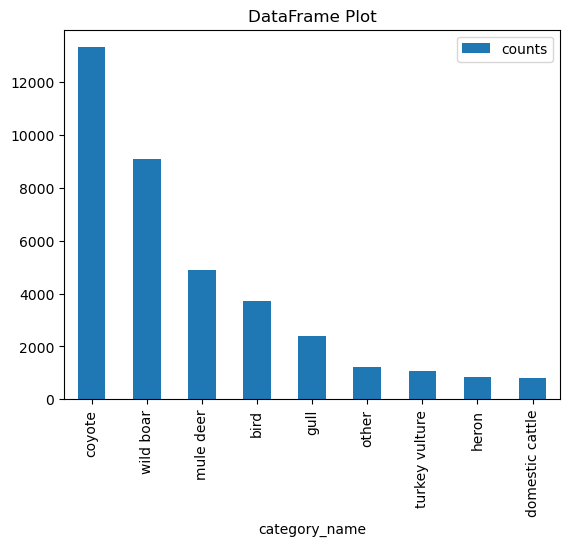

In [14]:
# plot classes
final_animl_cat_counts = get_category_counts(animl_filtered)
plot = final_animl_cat_counts.plot(kind="bar", x="category_name", y="counts", title="DataFrame Plot")

In [15]:
final_animl_cat_counts

,category_id,counts,category_name
1,49,13319,coyote
0,47,9083,wild boar
2,50,4903,mule deer
4,91,3718,bird
7,101,2383,gull
6,100,1213,other
5,97,1065,turkey vulture
8,102,833,heron
3,90,819,domestic cattle


### Step 4: Save cct file

In [16]:
# save as json file
out_file = os.path.join(home_path, f'animl-ml/classification/data/interim/{dataset}/animl_clean_cct.json')
with open(out_file, 'w') as f:
   json.dump(animl_filtered, f)

### TODO: everything from this point on needs to be updated and tested!

### LILA Data ('rats' from Island Conservation Cameratraps dataset)

In [ ]:
ic_annotations_file = os.path.join(raw_data_path, 'island_conservation.json')

In [ ]:
with open(ic_annotations_file, 'r') as f:
    ic = json.load(f)

In [ ]:
ic_cat_counts = get_category_counts(ic)
ic_cat_counts

#### Dataset-specific cleaning
For fixing bad CCT formatting or enriching CCT 

e.g. parsing `image['file_name']` to derive `image['location']`

In [ ]:
# parse IC's image['file_name'] to derive image['location']
for img in ic['images']:
    path = img['file_name'].split('/')[0:2]
    path = '/'.join(path)
    img['location'] = path

ic['images'][0]

In [ ]:
ic_categories_to_keep = [7, 3, 5, 37]  # rats, iguanas, cats, pigs
# from find_rat_locations.ipynb output:
ic_locations_to_keep = [
    'dominicanrepublic/camara116', 'dominicanrepublic/camara107', 
    'dominicanrepublic/camara106', 'dominicanrepublic/camara20', 
    'dominicanrepublic/camara115', 'dominicanrepublic/camara12', 
    'dominicanrepublic/camara32', 'dominicanrepublic/camara01', 
    'dominicanrepublic/camara108', 'dominicanrepublic/camara111', 
    'dominicanrepublic/camara117', 'dominicanrepublic/camara24', 
    'dominicanrepublic/camara30', 'ecuador1/ic1619', 'ecuador1/ic1616', 
    'chile/vaqueria', 'chile/frances02', 'puertorico/7a', 'puertorico/23', 
    'puertorico/2a', 'palau/cam02a', 'palau/cam09a', 'palau/cam10a', 
    'palau/cam13a', 'palau/cam14a', 'palau/cam01a', 'palau/cam04a', 
    'palau/cam06a', 'palau/cam07a', 'palau/cam08a', 'ecuador2/ic1605', 
    'ecuador2/ic1607', 'ecuador2/ic1618', 'micronesia/cam12', 
    'micronesia/cam13', 'micronesia/cam15', 'micronesia/cam03', 
    'micronesia/cam11', 'micronesia/cam10', 'micronesia/cam05', 
    'micronesia/cam08', 'micronesia/cam17', 'micronesia/cam14', 
    'micronesia/cam16', 'micronesia/cam02', 'micronesia/cam18', 
    'micronesia/cam04', 'micronesia/cam19', 'micronesia/cam06', 
    'micronesia/cam09'
]

ic_clean, rejects = clean_cct(ic, ic_categories_to_keep, ic_locations_to_keep)

In [ ]:
# subsample rat samples from 'micronesia/cam06'
# 'micronesia/cam06' has 10666 rats, while the location with the second highest ammount of rat samples has 640
# the baseline model splits included micronesia/cam06 in training and seems to have learned too much about the background of that location
img_lookup = {img['id']: img for img in ic_clean['images']}

print(f'Original annotation count: {len(ic_clean["annotations"])}')

all_rat_annos_at_micronesiacam06 = []
for anno in ic_clean['annotations']:
    if anno['category_id'] == 7:
        img = img_lookup[anno['image_id']]
        if img['location'] == 'micronesia/cam06':
              all_rat_annos_at_micronesiacam06.append(anno)

print(f'Found {len(all_rat_annos_at_micronesiacam06)} rat annotations at micronesia/cam06')

subsample_annos_at_micronesiacam06 = [anno['id'] for anno in random.sample(all_rat_annos_at_micronesiacam06, 600)]
print(f'Subsample count: {len(subsample_annos_at_micronesiacam06)}')

def subsample_fn(anno):
    img = img_lookup[anno['image_id']]
    if (anno['category_id'] == 7 and 
        img['location'] == 'micronesia/cam06' and
        anno['id'] not in subsample_annos_at_micronesiacam06):
        return False
    else:
        return True     

ic_clean['annotations'] = list(filter(subsample_fn, ic_clean['annotations']))
print(f'New annotation count: {len(ic_clean["annotations"])}')

In [ ]:
# remove known mislabed annotations
mislabbeled_annos = [
  '5fe812fa-df31-11ea-83e9-000d3a74c7de',
  '674305e8-df31-11ea-aeb4-000d3a74c7de',
  '675ff0ae-df31-11ea-9fe3-000d3a74c7de'
]

ic_clean['annotations'] = list(filter(lambda x: x['id'] not in mislabbeled_annos, ic_clean['annotations']))

In [ ]:
ic_cat_counts = get_category_counts(ic_clean)
ic_cat_counts

In [ ]:
# convert IC rat category ID to Animl's
for ann in ic_clean['annotations']:
    if ann['category_id'] == 7: # rat (IC)
        ann['category_id'] = 17 # rat (Animl)

for cat in ic_clean['categories']:
    if cat['id'] == 7:
        cat['id'] = 17

# ic_clean['annotations'][0]
ic_clean['categories']

### Combine datasets

In [ ]:
# merge datasets into one CCT dict
coco_out = {}
coco_out['images'] = animl_clean['images'] + ic_clean['images'] + buckeye_rats_clean['images']
coco_out['annotations'] = animl_clean['annotations'] + ic_clean['annotations'] + buckeye_rats_clean['annotations']
coco_out['categories'] = animl_clean['categories'] + ic_clean['categories']+ buckeye_rats_clean['categories'] 
coco_out['categories'] = [dict(t) for t in {tuple(d.items()) for d in coco_out['categories']}] # dedupe any dupliacte classes
coco_out['info'] = animl_clean['info']

print(f'combined dataset contains {len(coco_out["annotations"])} annotations in {len(coco_out["images"])} images of the following categories: \n {list(map(lambda x: x["name"], coco_out["categories"]))}')

In [ ]:
coco_out['categories'] 

In [ ]:
# sanity check
assert len(coco_out["annotations"]) == len(animl_clean["annotations"]) + len(ic_clean["annotations"]) + len(buckeye_rats_clean["annotations"])
assert len(coco_out["images"]) == len(animl_clean["images"]) + len(ic_clean["images"]) + len(buckeye_rats_clean["images"])
final_cat_counts = get_category_counts(coco_out)
final_cat_counts


In [ ]:
ic_clean['categories']

In [ ]:
coco_out['categories']

In [ ]:
final_cat_counts['counts'].sum()

In [ ]:
final_cat_counts['pct_of_total'] = (final_cat_counts['counts'] / final_cat_counts['counts'].sum()) * 100
final_cat_counts

In [ ]:
#plot the species distribution from the all data 
sns.barplot(data=final_cat_counts, x='category_name', y='counts')
# add labels and species numbers
# add number to each species

plt.xlabel('category_name')
plt.ylabel('Number of samples')
plt.title('Distribution of Animal Species in the Results')
plt.show()

In [ ]:
# save as json file
out_file = os.path.join(home_path, f'invasive-animal-detection/data/interim/{dataset}/combined_cct.json')
with open(out_file, 'w') as f:
   json.dump(coco_out, f)
